In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({
    'font.size': 20,
})

In [4]:
class LineEncoder:
    def __init__(self, volts=5, interval=1):
        self.volts = volts
        self.interval = interval
    
    def _iterate_binstr(self, binstr):
        for char in binstr:
            assert char in {'1', '0'}, 'Invalid binstring'
            yield int(char)
    
    def _plot(self, y, title, x=None, ticks=None, text=None):
        fig = plt.figure(figsize=(20,5))
        if ticks is None:
            ticks = [i * self.interval for i in range(len(y))]    
        if x is None:
            x = ticks
        # Add extra padding
        y.append(y[-1])
        if x != ticks:
            x.append(x[-1] + self.interval/2)
            ticks.append(ticks[-1] + self.interval)
        else:
            x.append(x[-1] + self.interval)
        # Plot graph
        plt.step(x, y, 'b', linewidth=3.0, where='post')
        plt.title(title)
        plt.xticks(ticks)
        plt.yticks(range(min(y), max(y) + 4))
        plt.grid(True)
        
        if text:
            for x, y, txt in text:
                plt.text(x, y, txt)
        plt.show()
    
    def encode_nrzl(self, binstr):
        y = []
        text = []
        for d in self._iterate_binstr(binstr):
            text.append(
                (len(y)*self.interval + self.interval/2.5, self.volts+1, d))
            y.append(d * self.volts)
        
        self._plot(y, f'NRZ-L of {binstr}', text=text)
    
    def encode_nrzi(self, binstr):
        y = []
        text = []
        val = True
        for d in self._iterate_binstr(binstr):
            if d == 1:
                val = not val
            text.append(
                (len(y)*self.interval + self.interval/2.5, self.volts+1, d))
            y.append(int(val) * self.volts)

        self._plot(y, f'NRZ-I of {binstr}', text=text)
    
    def encode_manchester(self, binstr):
        y = []
        x = []
        text = []
        for idx, d in enumerate(self._iterate_binstr(binstr)):
            if d == 1:
                y.extend([self.volts,0])
            else:
                y.extend([0,self.volts])
            
            midpoint = self.interval*idx + self.interval/2 
            x.append(self.interval*idx)
            x.append(midpoint)
            text.append(
                (midpoint - 0.1, self.volts+1, d))
        
        ticks=[i*self.interval for i in range(len(y)//2)]
        self._plot(
            x=x,
            y=y,
            title=f'Manchester of {binstr}',
            ticks=ticks,
            text=text,)

    
    def encode_diff_manchester(self, binstr):
        y = []
        x = []
        text = []
        val = True
        for idx, d in enumerate(self._iterate_binstr(binstr)):
            if d != 1:
                val = not val
            y.append(int(val) * self.volts)
            val = not val
            y.append(int(val) * self.volts)
            midpoint = self.interval*idx + self.interval/2
            x.append(self.interval * idx)
            x.append(midpoint)
            text.append(
                (midpoint - 0.1, self.volts+1, d))
        ticks=[i*self.interval for i in range(len(y)//2)]
        self._plot(
            x=x,
            y=y,
            title=f'Differential Manchester of {binstr}',
            ticks=ticks,
            text=text,)
    
    def encode_ami(self, binstr):
        y = []
        text = []
        val = False
        for d in self._iterate_binstr(binstr):
            text.append(
                (len(y)*self.interval + self.interval/2.5, self.volts+1, d))
            if d == 1:
                val = not val
                y.append(self.volts * (1 if val else -1))
            else:
                y.append(0)

        self._plot(
            y=y,
            title=f'AMI of {binstr}',
            text=text,)
        
    def encode_b8zs(self, binstr):
        new_str = binstr.replace('0'*8, '000VB0VB')
        y = []
        text = []
        val = False
        for d in new_str:
            text.append(
                (len(y)*self.interval + self.interval/2.5, self.volts+1, d))
            if d == '0':
                y.append(0)
            else:
                if d in {'1', 'B'}:
                    val = not val
                y.append(self.volts * (1 if val else -1))
        
        self._plot(
            y=y,
            text=text,
            title=f'B8ZS of {binstr} ({new_str})')
    
    def encode_hdb3(self, binstr):
        # Preprocess bitstr to replace 0000
        new_str = list(binstr)
        last_idx = 0
        idx = ''.join(new_str).find('0'*4)
        while idx >= 0:
            if new_str[last_idx:idx].count('1') % 2 == 0:
                new_str[idx:idx+4] = 'B00V'
            else:
                new_str[idx:idx+4] = '000V'
            last_idx = idx+4 
            idx = ''.join(new_str).find('0'*4)
        new_str = ''.join(new_str)
        # Plot
        y = []
        text = []
        val = False
        for d in new_str:
            text.append(
                (len(y)*self.interval + self.interval/2.5, self.volts+1, d))
            if d == '0':
                y.append(0)
            else:
                if d in {'1', 'B'}:
                    val = not val
                y.append(self.volts * (1 if val else -1))
        self._plot(
            y=y,
            text=text,
            title=f'HDB3 of {binstr} ({new_str})')

# l = LineEncoder(volts=5, interval=2)
# l.encode_nrzl('1101000000011111111')
# l.encode_nrzi('1101000000011111111')
# l.encode_manchester('101000110')
# l.encode_diff_manchester('101000110')
# l.encode_ami('010100111001')
# l.encode_b8zs('0000000011')
# l.encode_hdb3('110000100000000')

In [30]:
import random


def generate_bit_stream(length=30, repeating_zeros=None):
    '''
    Generates a random sequence of 1's and 0's.
    '''
    bitstr = list(bin(random.getrandbits(length))[2:])
    random.shuffle(bitstr)
    
    if repeating_zeros:
        assert repeating_zeros < length, "Repeating zeroes more than bit string"
        z_start = random.randrange(0, length - repeating_zeros + 1)
        z_end = z_start + repeating_zeros
        bitstr[z_start:z_end] = '0' * repeating_zeros

    return ''.join(bitstr)


def longest_palindromic_seq(string):
    pass

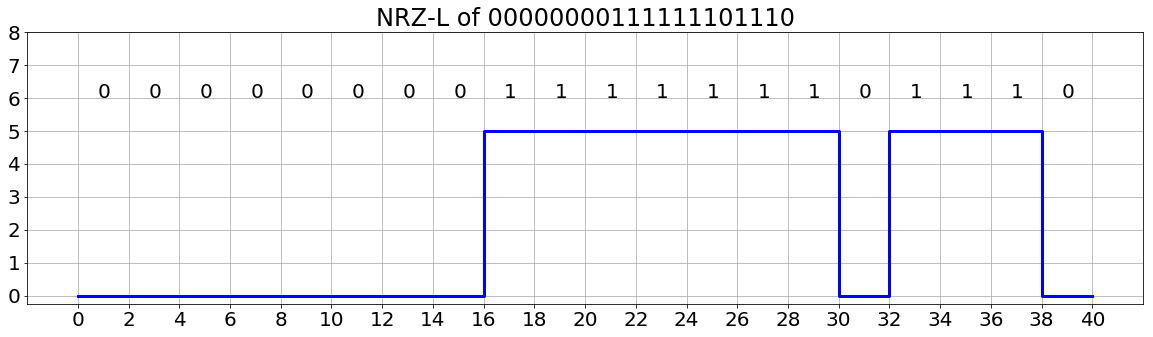

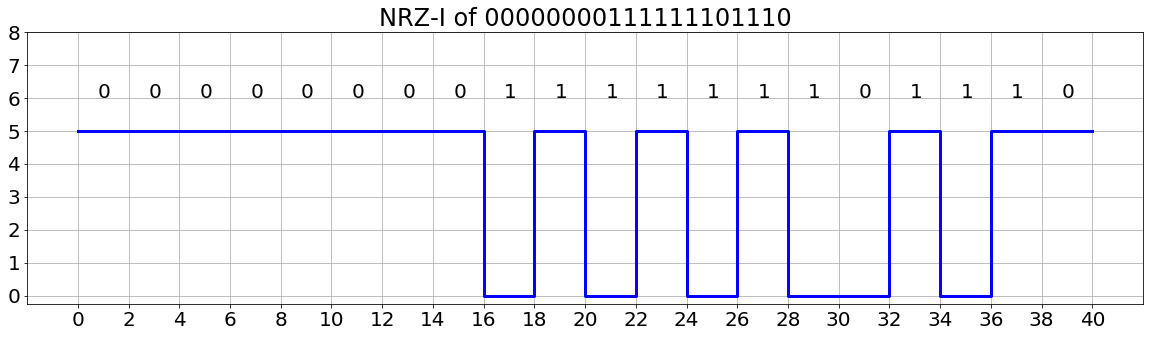

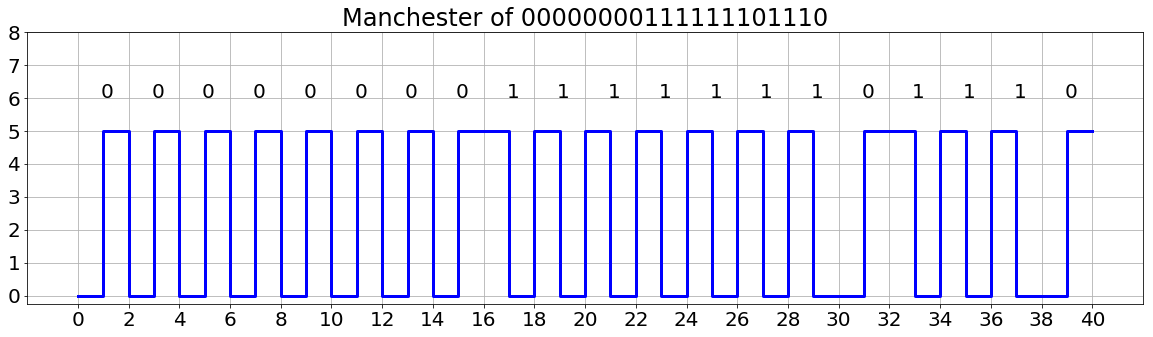

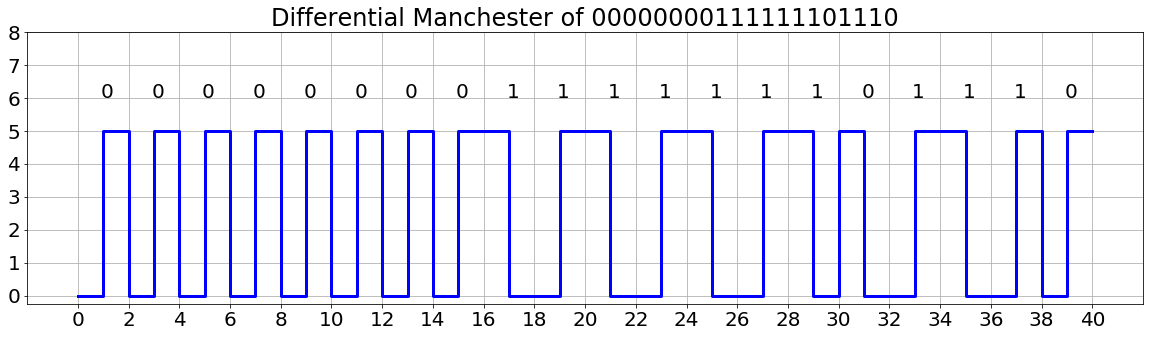

Bitstream: 00000000111111101110
Select the scrambling scheme for AMI
1. B8ZS
2. HDB3
3. None

Choice: 1


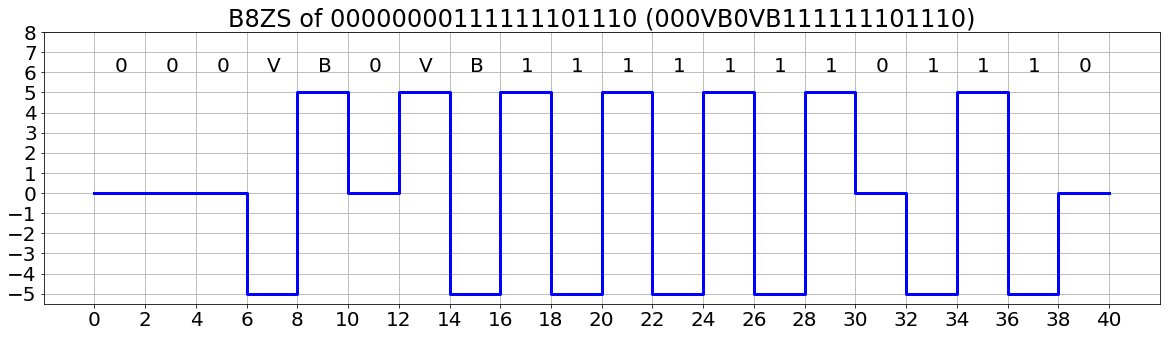

Bitstream: 00000000111111101110
Select the encoding to perform
1. NRZ-L
2. NRZ-I
3. Manchester
4. Differential Manchester
5. AMI
6. All
7. Back



In [ ]:
from IPython.display import clear_output


def cli_binstring():
    while True:
        print('Enter bitstream\n'
             '1. Generate random stream\n'
             '2. Generate random stream with repeating subsequences\n'
             '3. Enter custom bitstream\n')
        try:
            o = int(input('Choice: '))
            assert o in range(1, 4)
            break
        except (ValueError, AssertionError):
            clear_output()
            print('Invalid input.\n\n')
            continue
    if o in {1, 2}:
        while True:
            try:
                length = int(input('Bitstream length: '))
                break
            except ValueError:
                print('Invalid input.\n')
                continue
        
        repeating_zeros = None
        if o == 2:
            while True:
                try:
                    repeating_zeros = int(input("Length of repeating 0's: "))
                    break
                except ValueError:
                    print('Invalid input.\n')
                    continue
        
        return generate_bit_stream(length, repeating_zeros)
    else:
        binstr = input('Enter bitstream:')
    return binstr


def cli_encode_ami(encoder, binstr):
    options = {
        1: encoder.encode_b8zs,
        2: encoder.encode_hdb3,
        3: encoder.encode_ami,
    }
    
    while True:
        print(f'Bitstream: {binstr}')
        print('Select the scrambling scheme for AMI\n'
             '1. B8ZS\n'
             '2. HDB3\n'
             '3. None\n')
        try:
            o = int(input('Choice: '))
            assert o in range(1, 4)
            break
        except (ValueError, AssertionError):
            clear_output()
            print('Invalid input.\n\n')
            continue

    options[o](binstr)


def cli_encode(binstr):
    encoder = LineEncoder(volts=5, interval=2)
    options = {
        1: encoder.encode_nrzl,
        2: encoder.encode_nrzi,
        3: encoder.encode_manchester,
        4: encoder.encode_diff_manchester,
    }
    
    while True:
        print(f'Bitstream: {binstr}')
        print('Select the encoding to perform\n'
             '1. NRZ-L\n'
             '2. NRZ-I\n'
             '3. Manchester\n'
             '4. Differential Manchester\n'
             '5. AMI\n'
             '6. All\n'
             '7. Back\n')
        try:
            o = int(input('Choice: '))
            assert o in range(1, 8)
        except (ValueError, AssertionError):
            clear_output()
            print('Invalid input.\n\n')
            continue
        
        clear_output()
        if o not in {5, 6, 7}:
            options[o](binstr)
        elif o == 5:
            cli_encode_ami(encoder, binstr)
        elif o == 6:
            for i in range(1, 5):
                options[i](binstr)
            cli_encode_ami(encoder, binstr)
        else:
            break


def cli():
    while True:
        binstr = cli_binstring()
        clear_output()
        cli_encode(binstr)


cli()